In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

#### Importing data

In [2]:
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

In [3]:

#returns with dididend payments yearly and monthly
Y_ret = pd.read_excel(filepath + 'DS_RI_USD_Y.xlsx')
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')

#market value yearly and monthly
Y_mval = pd.read_excel(filepath + 'DS_MV_USD_Y.xlsx')
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')

#revenue yearly
revenue = pd.read_excel(filepath + 'DS_REV_USD_Y.xlsx')

#risk free rate
rfr = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')

#Escores
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')

#Companies and Regions
companies = pd.read_excel(filepath + 'Static.xlsx')


#### Only consider Pacific companies

In [4]:
# Merge data with companies on ISIN and keep only records where Region = PAC
#   [companies['Region'].isin(['PAC'])] is used to filter the rows where Region = PAC

Y_ret = Y_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_ret = M_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_mval = Y_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_mval = M_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
revenue = revenue.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
escore = escore.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')

# Drop the duplicated columns from the merge
for df in [M_ret, Y_ret, M_mval, Y_mval, revenue, escore]:
    df.drop(columns=['Region'], inplace=True)


#### Melting dataframes to have them in long format

In [5]:
M_ret_w = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
Y_ret_w = Y_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
M_mval_w = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
Y_mval_w = Y_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
revenue_w = revenue.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="REVENUE")
escore_w = escore.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="ESCORE")

#### Making sure the data is correct

In [6]:
for df in [M_ret_w, M_mval_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)
    #date format d.m.y
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

for df in [Y_ret_w, Y_mval_w, revenue_w, escore_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)

#### Compute Annualized returns 

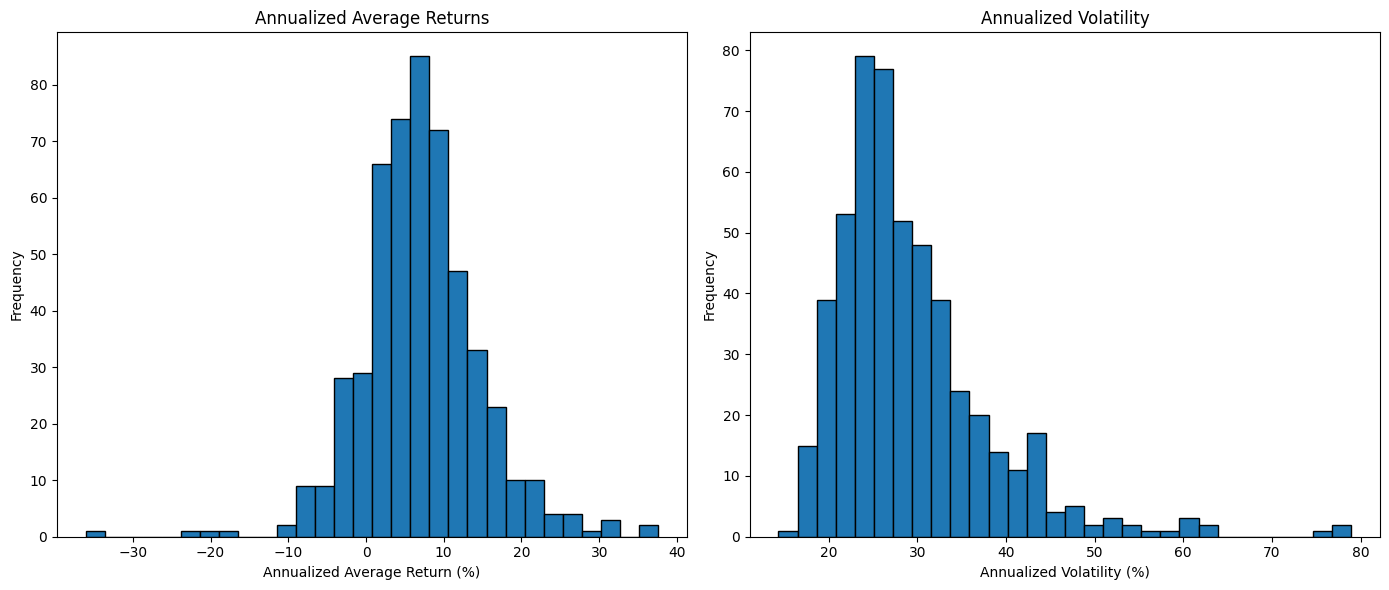

Correlation between annualized average returns and volatilities: 0.069


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data from 2014 to 2024
dfe1 = M_ret_w[(M_ret_w['DATE'] >= '2013-12-31') & (M_ret_w['DATE'] <= '2024-12-31')]

# Compute monthly returns in percentage
dfe1['RET_PCT'] = dfe1.groupby('ISIN')['RETURN'].pct_change() * 100

# Drop the first row (January 2014) of each ISIN
dfe1 = dfe1.dropna(subset=['RET_PCT'])

# Compute annualized average return and annualized volatility
annualized_returns = dfe1.groupby('ISIN')['RET_PCT'].mean() * 12
annualized_volatility = dfe1.groupby('ISIN')['RET_PCT'].std() * np.sqrt(12)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(annualized_returns, bins=30, edgecolor='k')
plt.title('Annualized Average Returns')
plt.xlabel('Annualized Average Return (%)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(annualized_volatility, bins=30, edgecolor='k')
plt.title('Annualized Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute correlation between individual average returns and volatilities
correlation = annualized_returns.corr(annualized_volatility)
print(f'Correlation between annualized average returns and volatilities: {correlation:.3f}')

# Comment on the results
# - Analyze the shape and spread of the histograms.
# - Discuss any notable features or outliers.
# - Interpret the correlation coefficient and its implications.

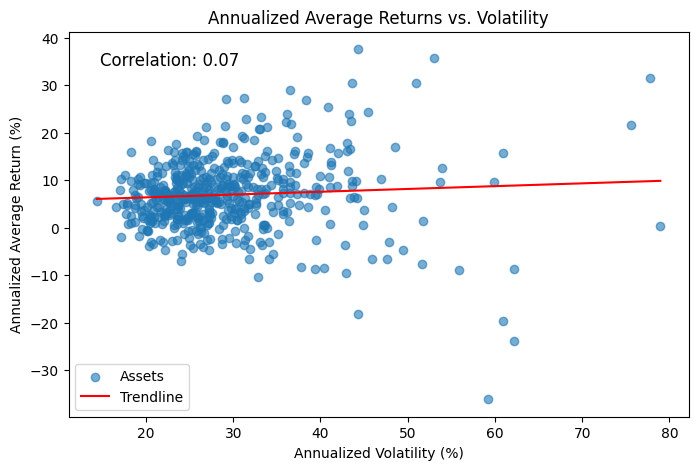

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(annualized_volatility, annualized_returns, alpha=0.6, label='Assets')
plt.title('Annualized Average Returns vs. Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Average Return (%)')

# Compute trendline
slope, intercept = np.polyfit(annualized_volatility, annualized_returns, 1)
x = np.linspace(annualized_volatility.min(), annualized_volatility.max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label='Trendline')

# Display correlation
plt.text(
    0.05, 0.95,
    f'Correlation: {correlation:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.legend()
plt.show()

Equally-Weighted Portfolio:
Annualized Return      : 6.14%
Annualized Volatility  : 14.30%
Sharpe Ratio           : 0.32
Minimum Monthly Return : -13.49%
Maximum Monthly Return : 13.09%

Value-Weighted Portfolio:
Annualized Return      : 10.96%
Annualized Volatility  : 13.48%
Sharpe Ratio           : 0.70
Minimum Monthly Return : -9.58%
Maximum Monthly Return : 13.95%


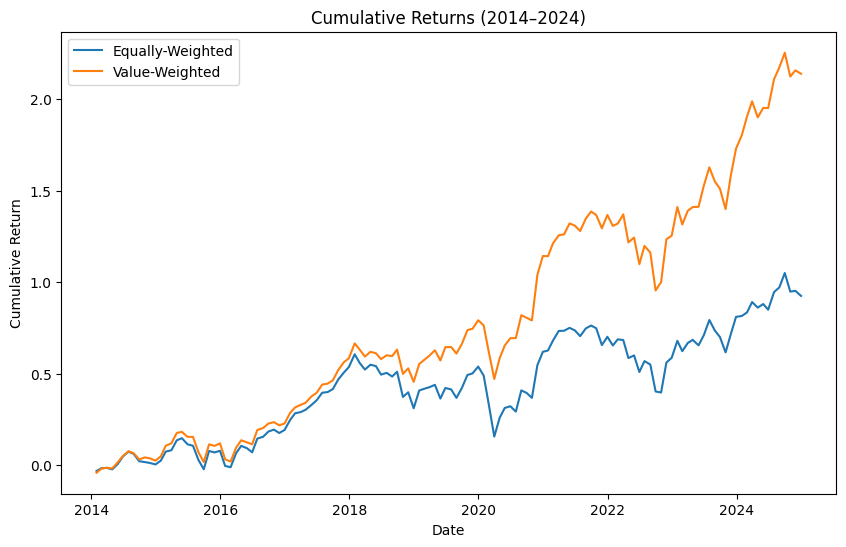

In [14]:
# The necessary data (dfe1, M_mval_w, rfr), functions, and imports have already been defined in previous cells.

# 1. Equally-Weighted Portfolio:
#    Each month, take a simple average of the percentage returns (RET_PCT).
ew_portfolio = dfe1.groupby('DATE')['RET_PCT'].mean().reset_index()
ew_portfolio['r'] = ew_portfolio['RET_PCT'] / 100.0

# 2. Value-Weighted Portfolio:
#    Use market values (MKT_VAL) from the monthly data to weight each firm’s return.
#    Merge them if not already merged, then compute weighted average.
data_vw = dfe1.drop(columns=['MKT_VAL'], errors='ignore')
vw_data = pd.merge(data_vw, M_mval_w, on=["NAME", "ISIN", "DATE"], how="inner")
vw_data["MKT_VAL"] = pd.to_numeric(vw_data["MKT_VAL"], errors="coerce")
vw_data = vw_data.dropna(subset=["MKT_VAL", "RET_PCT"])

def weighted_return(grp):
    total_cap = grp["MKT_VAL"].sum()
    return (grp["RET_PCT"] * grp["MKT_VAL"] / total_cap).sum()

vw_portfolio = vw_data.groupby("DATE").apply(weighted_return).reset_index(name="vw_RET_PCT")
vw_portfolio["r"] = vw_portfolio["vw_RET_PCT"] / 100.0

# 3. Combine and compute cumulative returns
port_returns = pd.merge(
    ew_portfolio[["DATE", "r"]],
    vw_portfolio[["DATE", "r"]],
    on="DATE",
    how="inner",
    suffixes=("_ew", "_vw")
).sort_values("DATE")

port_returns["cum_ew"] = (1 + port_returns["r_ew"]).cumprod() - 1
port_returns["cum_vw"] = (1 + port_returns["r_vw"]).cumprod() - 1

# 4. Function to compute portfolio statistics
def portfolio_stats(r_series):
    n = len(r_series)
    cumulative = (1 + r_series).prod()
    ann_return = cumulative ** (12 / n) - 1
    ann_vol = r_series.std() * np.sqrt(12)
    # Approximate risk-free rate over this period
    rf_temp = rfr.copy()
    rf_temp["year"] = rf_temp["Unnamed: 0"].astype(str).str[:4]
    rf_temp["month"] = rf_temp["Unnamed: 0"].astype(str).str[4:6]
    rf_temp["DATE"] = pd.to_datetime(rf_temp["year"] + "-" + rf_temp["month"] + "-01") + pd.offsets.MonthEnd(0)
    rf_temp = rf_temp[(rf_temp["DATE"] >= port_returns["DATE"].min()) &
                      (rf_temp["DATE"] <= port_returns["DATE"].max())]
    ann_rf = (rf_temp["RF"].mean() / 100) * 12
    sharpe = (ann_return - ann_rf) / ann_vol if ann_vol != 0 else np.nan
    return ann_return, ann_vol, sharpe, r_series.min(), r_series.max()

ew_ret_stats = portfolio_stats(port_returns["r_ew"])
vw_ret_stats = portfolio_stats(port_returns["r_vw"])

# 5. Print statistics
print("Equally-Weighted Portfolio:")
print(f"Annualized Return      : {ew_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {ew_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {ew_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {ew_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {ew_ret_stats[4]:.2%}\n")

print("Value-Weighted Portfolio:")
print(f"Annualized Return      : {vw_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {vw_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {vw_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {vw_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {vw_ret_stats[4]:.2%}")

# 6. Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(port_returns["DATE"], port_returns["cum_ew"], label="Equally-Weighted")
plt.plot(port_returns["DATE"], port_returns["cum_vw"], label="Value-Weighted")
plt.title("Cumulative Returns (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

Equally-Weighted Portfolio:
Annualized Return      : 6.14%
Annualized Volatility  : 14.30%
Sharpe Ratio           : 0.32
Minimum Monthly Return : -13.49%
Maximum Monthly Return : 13.09%

Value-Weighted Portfolio:
Annualized Return      : 10.96%
Annualized Volatility  : 13.48%
Sharpe Ratio           : 0.70
Minimum Monthly Return : -9.58%
Maximum Monthly Return : 13.95%


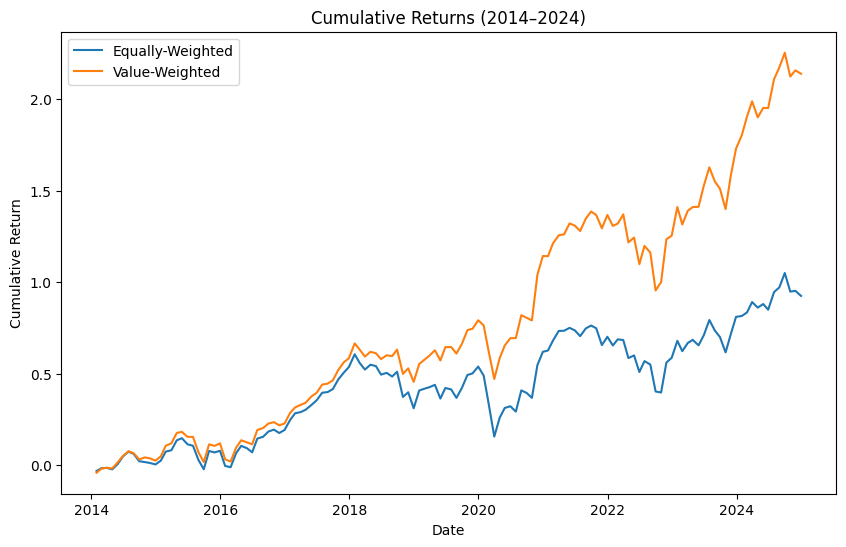

In [12]:
# Filter the monthly returns data for the period 2014–2024.
# (dfe1 was already filtered in cell 11 for dates between 2013-12-31 and 2024-12-31.)
data = dfe1[dfe1['DATE'] >= '2014-01-31'].copy()

# -----------------------------
# 1. Equally-Weighted Portfolio
# For each month, compute the average of the monthly percentage return (RET_PCT).
# Then express it in decimal form for return computations.
ew_portfolio = data.groupby('DATE')['RET_PCT'].mean().reset_index()
ew_portfolio['r'] = ew_portfolio['RET_PCT'] / 100.0

# -----------------------------
# 2. Value-Weighted Portfolio
# We need to use market values from the monthly market data.
# Remove the 'MKT_VAL' column from data to avoid duplicate columns upon merge.
data = data.drop(columns=["MKT_VAL"])
vw_data = pd.merge(data, M_mval_w, on=["NAME", "ISIN", "DATE"], how="inner")
# Make sure the market value column is numeric.
vw_data["MKT_VAL"] = pd.to_numeric(vw_data["MKT_VAL"], errors="coerce")
vw_data = vw_data.dropna(subset=["MKT_VAL", "RET_PCT"])

# For each date, compute the portfolio return as the weighted average of individual RET_PCT,
# where weights are given by each firm’s market cap.
def weighted_return(grp):
    total_cap = grp["MKT_VAL"].sum()
    return (grp["RET_PCT"] * grp["MKT_VAL"] / total_cap).sum()

vw_portfolio = vw_data.groupby("DATE").apply(lambda g: weighted_return(g)).reset_index(name="vw_RET_PCT")
vw_portfolio["r"] = vw_portfolio["vw_RET_PCT"] / 100.0

# -----------------------------
# 3. Align and Compute Cumulative Returns
# Merge the two portfolio return time series on DATE for plotting.
port_returns = pd.merge(
    ew_portfolio[["DATE", "r"]],
    vw_portfolio[["DATE", "r"]],
    on="DATE",
    how="inner",
    suffixes=("_ew", "_vw")
).sort_values("DATE")

# Compute cumulative returns (starting from 0) using compound returns.
port_returns["cum_ew"] = (1 + port_returns["r_ew"]).cumprod() - 1
port_returns["cum_vw"] = (1 + port_returns["r_vw"]).cumprod() - 1

# -----------------------------
# 4. Compute Statistics
# We compute: annualized average return, annualized volatility, Sharpe ratio,
# minimum and maximum monthly returns.
# To compute a Sharpe ratio, we need a risk‐free rate.
# Here we use the risk free data from rfr.
def portfolio_stats(r_series):
    n = len(r_series)
    # Compute geometric annualized return over n months.
    cumulative = (1 + r_series).prod()
    ann_ret = cumulative ** (12 / n) - 1
    ann_vol = r_series.std() * np.sqrt(12)
    # Process risk-free data: rfr has a column 'Unnamed: 0' with YYYYMM and 'RF' in percent.
    rf_temp = rfr.copy()
    rf_temp["year"] = rf_temp["Unnamed: 0"].astype(str).str[:4]
    rf_temp["month"] = rf_temp["Unnamed: 0"].astype(str).str[4:6]
    # Construct a date column (using the month-end as convention).
    rf_temp["DATE"] = pd.to_datetime(rf_temp["year"] + "-" + rf_temp["month"] + "-01") + pd.offsets.MonthEnd(0)
    rf_temp = rf_temp[(rf_temp["DATE"] >= port_returns["DATE"].min()) &
                      (rf_temp["DATE"] <= port_returns["DATE"].max())]
    # Convert risk-free rate to decimal.
    mean_rf = (rf_temp["RF"] / 100).mean()
    ann_rf = mean_rf * 12
    sharpe = (ann_ret - ann_rf) / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe, r_series.min(), r_series.max()

ew_ret_stats = portfolio_stats(port_returns["r_ew"])
vw_ret_stats = portfolio_stats(port_returns["r_vw"])

print("Equally-Weighted Portfolio:")
print(f"Annualized Return      : {ew_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {ew_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {ew_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {ew_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {ew_ret_stats[4]:.2%}\n")

print("Value-Weighted Portfolio:")
print(f"Annualized Return      : {vw_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {vw_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {vw_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {vw_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {vw_ret_stats[4]:.2%}")

# -----------------------------
# 5. Plot Cumulative Returns
plt.figure(figsize=(10, 6))
plt.plot(port_returns["DATE"], port_returns["cum_ew"], label="Equally-Weighted")
plt.plot(port_returns["DATE"], port_returns["cum_vw"], label="Value-Weighted")
plt.title("Cumulative Returns (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()